In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

D:\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [47]:
tf.__version__

'1.8.0'

# Training

In [2]:
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
import h5py
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from nltk.tokenize.treebank import TreebankWordTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import SmoothingFunction
import pandas as pd
from numpy import asarray
from numpy import zeros
from pickle import dump
from gensim.models import Word2Vec
from os import listdir
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot
import string
import json
import keras

D:\Anaconda\envs\tensorflow\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [4]:
train_list=os.listdir("coco/full/train2017")

In [5]:
def load_descriptions(filename='file',image_list=[]):
    with open(filename) as json_data:
        f=json.load(json_data)
    
    description=dict()
    for i in range(len(f["annotations"])):
        if "caption" in f["annotations"][i].keys():
            image_id=f["annotations"][i]["image_id"]
            image_id=format(image_id, '012d')
            if image_id+".jpg" in image_list:
                description[image_id]=f["annotations"][i]["caption"]
            
    return(description)

In [6]:
#descriptions = load_descriptions("coco/annotations/captions_train2017.json",train_list)
#print('Loaded: %d ' % len(descriptions))

In [7]:
def clean_descriptions(descriptions):
    tree_tokenize=TreebankWordTokenizer()
    for key, desc in descriptions.items():    
        desc=desc.lower()
        desc=tree_tokenize.tokenize(desc)
        desc=' '.join(desc)
        desc=desc.replace("n't","not")
        desc=desc.replace("'s","")
        for c in string.punctuation:
            desc=desc.replace(c,"")
        desc=desc.split()
        desc = [word for word in desc if len(word)>1]
        descriptions[key] =  ' '.join(desc)

In [8]:
#clean_descriptions(descriptions)

In [9]:
# all_tokens = ' '.join(descriptions.values()).split()
# vocabulary = set(all_tokens)
# print('Number of words in vocabulary: %d ' % len(vocabulary))

In [10]:
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [11]:
# save_doc(descriptions,"coco/full/description.txt")

In [12]:
def extract_features(input_directory="file",output_directory="file"):
    # load the model
    import h5py
    f = h5py.File(output_directory)
    in_layer = Input(shape=(224, 224, 3))
    model = InceptionV3(include_top=False, input_tensor=in_layer)
    print(model.summary())
    # extract features from each photo
    features = dict()
    i=0
    for name in listdir(input_directory):
        # load an image from file
        filename = input_directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the Inception model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        f.create_dataset(image_id, data=np.array(feature, dtype=np.float32))
        print(i)
        i+=1
    f.close()

In [13]:
def load_clean_descriptions(filename):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

In [14]:
train_descriptions=load_clean_descriptions("coco/full/description.txt")

In [15]:
dataset=train_descriptions.keys()

In [16]:
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
word_to_index=pd.read_csv("coco/full/tokens.csv",header=None, index_col=0, squeeze=True)

In [18]:
vocab_size = len(word_to_index) + 1

In [19]:
def text_to_sequences(desc,tokens):    
    text_to_sequences=list()
    for i in desc.split():
        if i=="nan":
            continue
        text_to_sequences.append(tokens[i])
    return text_to_sequences

In [20]:
max_length = max(len(s.split()) for s in list(train_descriptions.values()))

In [21]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer) + 1
    # integer encode the description
    seq = text_to_sequences(desc,tokenizer)
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y)
    return [Ximages, XSeq, y]

In [22]:
def data_generator(descriptions, features_directory, tokenizer, max_length, n_step):
    # loop until we finish training
    f = h5py.File(features_directory, 'r')
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = f[image_id].value[0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]
    f.close()

In [23]:
def word_for_id(integer, tokenizer):
    if integer in tokenizer.values:
        return word_to_index[word_to_index==integer].index[0]
    else:
        return ""

In [24]:
def generate_desc_beam(model, tokenizer, photo, max_length,k=10):
    # seed the generation process
    in_text = ""
    sequences = [[list([1]), 1.0]]
    # iterate over the whole length of the sequence
    for i in range(max_length-1):
        # integer encode input sequence
        all_candidates = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            sequence = pad_sequences([seq], maxlen=max_length)
            predict=model.predict([photo,sequence],verbose=0)
            for j in range(len(predict[0])):
                candidate = [seq + [j], score * -np.log(predict[0][j]+1e-323)]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
        word=word_for_id(sequences[0][0][-1], tokenizer)
        if word is None:
            break
        if word == 'endseq':
            break
    for i in sequences[0][0]:
        word=word_for_id(i, tokenizer)
        in_text=in_text+" "+word
    return in_text

In [25]:
# lines = [s.split() for s in train_descriptions.values()]
# model = Word2Vec(lines, size=500, window=5, workers=8, min_count=1)
# # summarize vocabulary size in model
# words = list(model.wv.vocab)
# print('Vocabulary size: %d' % len(words))
 
# # save model in ASCII (word2vec) format
# filename = 'coco/full/custom_embedding.txt'
# model.wv.save_word2vec_format(filename, binary=False)

In [26]:
# load the whole embedding into memory
# embedding = dict()
# file = open('coco/full/custom_embedding.txt')
# for line in file:
# 	values = line.split()
# 	word = values[0]
# 	coefs = asarray(values[1:], dtype='float32')
# 	embedding[word] = coefs
# file.close()
# print('Embedding Size: %d' % len(embedding))

In [27]:
# # summarize vocabulary
# all_tokens = ' '.join(train_descriptions.values()).split()
# vocabulary = set(all_tokens)
# print('Vocabulary Size: %d' % len(vocabulary))

In [28]:
# cust_embedding = dict()
# for word in vocabulary:
# 	# check if word in embedding
# 	if word not in embedding:
# 		continue
# 	cust_embedding[word] = embedding[word]
# print('Custom Embedding %d' % len(cust_embedding))

In [29]:
# dump(cust_embedding, open('coco/full/word2vec_embedding.pkl', 'wb'))
# print('Saved Embedding')

In [30]:
def load_embedding(tokenizer, vocab_size, max_length):
    # load the tokenizer
    embedding = load(open('coco/full/word2vec_embedding.pkl', 'rb'))
    dimensions = 500
    trainable = False
    # create a weight matrix for words in training docs
    weights = zeros((vocab_size, dimensions))
    # walk words in order of tokenizer vocab to ensure vectors are in the right index
    for i in tokenizer.index:
        if i not in embedding:
            continue
        weights[tokenizer[i]] = embedding[i]
    layer = Embedding(vocab_size, dimensions, weights=[weights], input_length=max_length, trainable=trainable, mask_zero=True)
    return layer

In [31]:
def define_model(tokenizer, vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(5, 5, 2048))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = load_embedding(tokenizer, vocab_size, max_length)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(256)(merged)
    lm3 = Dense(256, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
verbose = 1
n_photos_per_update = 128
n_batches_per_epoch = len(train_descriptions)/n_photos_per_update

In [33]:
model = define_model(word_to_index,vocab_size, max_length)

In [25]:
del model

In [26]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=1, verbose=verbose)

Epoch 1/1
925/924 [==============================] - 3615s 4s/step - loss: 4.8208 - acc: 0.2182


In [30]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=6,initial_epoch=1, verbose=verbose)

Epoch 2/6
925/924 [==============================] - 3673s 4s/step - loss: 3.5903 - acc: 0.3296
Epoch 3/6
925/924 [==============================] - 3601s 4s/step - loss: 3.3272 - acc: 0.3519
Epoch 4/6
925/924 [==============================] - 3589s 4s/step - loss: 3.1841 - acc: 0.3640
Epoch 5/6
925/924 [==============================] - 3644s 4s/step - loss: 3.0846 - acc: 0.3710
Epoch 6/6
925/924 [==============================] - 3713s 4s/step - loss: 3.0054 - acc: 0.3771


In [33]:
keras.models.save_model(model,"coco/full/checkpoints/epoch9")

In [152]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=46,initial_epoch=37, verbose=verbose)

Epoch 38/46
925/924 [==============================] - 3938s 4s/step - loss: 2.3569 - acc: 0.4535
Epoch 39/46
925/924 [==============================] - 3750s 4s/step - loss: 2.3508 - acc: 0.4546
Epoch 40/46
925/924 [==============================] - 3680s 4s/step - loss: 2.3451 - acc: 0.4553
Epoch 41/46
925/924 [==============================] - 3717s 4s/step - loss: 2.3412 - acc: 0.4558
Epoch 42/46
925/924 [==============================] - 3753s 4s/step - loss: 2.3414 - acc: 0.4555
Epoch 43/46
925/924 [==============================] - 3816s 4s/step - loss: 2.3366 - acc: 0.4566
Epoch 44/46
925/924 [==============================] - 3834s 4s/step - loss: 2.3260 - acc: 0.4581
Epoch 45/46
925/924 [==============================] - 3870s 4s/step - loss: 2.3204 - acc: 0.4588
Epoch 46/46
925/924 [==============================] - 3894s 4s/step - loss: 2.3157 - acc: 0.4597


In [169]:
K.set_value(model.optimizer.lr,".0001")

In [26]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=86,initial_epoch=78, verbose=verbose)

Epoch 79/86
925/924 [==============================] - 4107s 4s/step - loss: 2.0369 - acc: 0.5101
Epoch 80/86
925/924 [==============================] - 3931s 4s/step - loss: 2.0204 - acc: 0.5144
Epoch 81/86
925/924 [==============================] - 3835s 4s/step - loss: 2.0099 - acc: 0.5170
Epoch 82/86
925/924 [==============================] - 3806s 4s/step - loss: 2.0014 - acc: 0.5190
Epoch 83/86
925/924 [==============================] - 3815s 4s/step - loss: 1.9940 - acc: 0.5207
Epoch 84/86
925/924 [==============================] - 3822s 4s/step - loss: 1.9872 - acc: 0.5222
Epoch 85/86
925/924 [==============================] - 3852s 4s/step - loss: 1.9809 - acc: 0.5237
Epoch 86/86
925/924 [==============================] - 3906s 4s/step - loss: 1.9751 - acc: 0.5251


In [26]:
keras.models.save_model(model,"coco/full/checkpoints/epoch122")

In [35]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=98,initial_epoch=91, verbose=verbose)

Epoch 92/98
925/924 [==============================] - 3795s 4s/step - loss: 1.9469 - acc: 0.5312
Epoch 93/98
925/924 [==============================] - 3718s 4s/step - loss: 1.9424 - acc: 0.5323
Epoch 94/98
925/924 [==============================] - 3693s 4s/step - loss: 1.9381 - acc: 0.5333
Epoch 95/98
925/924 [==============================] - 3706s 4s/step - loss: 1.9340 - acc: 0.5342
Epoch 96/98
925/924 [==============================] - 3739s 4s/step - loss: 1.9301 - acc: 0.5351
Epoch 97/98
925/924 [==============================] - 3778s 4s/step - loss: 1.9263 - acc: 0.5360
Epoch 98/98
925/924 [==============================] - 3810s 4s/step - loss: 1.9225 - acc: 0.5368


In [27]:
model.fit_generator(data_generator(train_descriptions,features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=158,initial_epoch=150, verbose=verbose)

Epoch 151/158
925/924 [==============================] - 3730s 4s/step - loss: 1.8064 - acc: 0.5617
Epoch 152/158
925/924 [==============================] - 3789s 4s/step - loss: 1.8010 - acc: 0.5634
Epoch 153/158
925/924 [==============================] - 3880s 4s/step - loss: 1.7977 - acc: 0.5642
Epoch 154/158
925/924 [==============================] - 3807s 4s/step - loss: 1.7953 - acc: 0.5648
Epoch 155/158
925/924 [==============================] - 3781s 4s/step - loss: 1.7931 - acc: 0.5654
Epoch 156/158
925/924 [==============================] - 3757s 4s/step - loss: 1.7911 - acc: 0.5660
Epoch 157/158
925/924 [==============================] - 3790s 4s/step - loss: 1.7890 - acc: 0.5665
Epoch 158/158
925/924 [==============================] - 4033s 4s/step - loss: 1.7871 - acc: 0.5669


In [65]:
model.fit_generator(data_generator(dict(sorted(train_descriptions.items())),features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=189,initial_epoch=177, verbose=verbose)

Epoch 178/189
925/924 [==============================] - 3753s 4s/step - loss: 1.7583 - acc: 0.5734
Epoch 179/189
925/924 [==============================] - 3759s 4s/step - loss: 1.7558 - acc: 0.5741
Epoch 180/189
925/924 [==============================] - 3815s 4s/step - loss: 1.7541 - acc: 0.5745
Epoch 181/189
925/924 [==============================] - 35545s 38s/step - loss: 1.7524 - acc: 0.5750
Epoch 182/189
925/924 [==============================] - 3880s 4s/step - loss: 1.7508 - acc: 0.5754
Epoch 183/189
925/924 [==============================] - 3815s 4s/step - loss: 1.7493 - acc: 0.5758
Epoch 184/189
925/924 [==============================] - 3768s 4s/step - loss: 1.7478 - acc: 0.5761
Epoch 185/189
925/924 [==============================] - 4282s 5s/step - loss: 1.7464 - acc: 0.5766
Epoch 186/189
925/924 [==============================] - 3816s 4s/step - loss: 1.7450 - acc: 0.5768
Epoch 187/189
925/924 [==============================] - 3857s 4s/step - loss: 1.7437 - acc: 0.577

In [24]:
model=keras.models.load_model("coco/full/checkpoints/epoch240")

In [25]:
K.set_value(model.optimizer.lr,".00001")

In [26]:
model.fit_generator(data_generator(dict(sorted(train_descriptions.items())),features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=195,initial_epoch=189, verbose=verbose)

Epoch 190/195
925/924 [==============================] - 4154s 4s/step - loss: 1.7261 - acc: 0.5810
Epoch 191/195
925/924 [==============================] - 3996s 4s/step - loss: 1.7211 - acc: 0.5824
Epoch 192/195
925/924 [==============================] - 3986s 4s/step - loss: 1.7194 - acc: 0.5829
Epoch 193/195
925/924 [==============================] - 3827s 4s/step - loss: 1.7184 - acc: 0.5831
Epoch 194/195
925/924 [==============================] - 3774s 4s/step - loss: 1.7176 - acc: 0.5834
Epoch 195/195
925/924 [==============================] - 3742s 4s/step - loss: 1.7169 - acc: 0.5836


In [24]:
model=keras.models.load_model("coco/full/checkpoints/epoch224")

In [25]:
model.fit_generator(data_generator(dict(sorted(train_descriptions.items())),features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=232,initial_epoch=224,verbose=verbose)

Epoch 225/232
925/924 [==============================] - 4086s 4s/step - loss: 1.7079 - acc: 0.5858
Epoch 226/232
925/924 [==============================] - 3973s 4s/step - loss: 1.7076 - acc: 0.5859
Epoch 227/232
925/924 [==============================] - 3960s 4s/step - loss: 1.7073 - acc: 0.5859
Epoch 228/232
925/924 [==============================] - 3914s 4s/step - loss: 1.7071 - acc: 0.5860
Epoch 229/232
925/924 [==============================] - 3848s 4s/step - loss: 1.7069 - acc: 0.5860
Epoch 230/232
925/924 [==============================] - 3811s 4s/step - loss: 1.7067 - acc: 0.5861
Epoch 231/232
925/924 [==============================] - 3811s 4s/step - loss: 1.7064 - acc: 0.5861
Epoch 232/232
925/924 [==============================] - 3833s 4s/step - loss: 1.7062 - acc: 0.5862


In [32]:
model.fit_generator(data_generator(dict(sorted(train_descriptions.items())),features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=240,initial_epoch=232,verbose=verbose)

Epoch 233/240
925/924 [==============================] - 5228s 6s/step - loss: 1.7060 - acc: 0.5862
Epoch 234/240
925/924 [==============================] - 3871s 4s/step - loss: 1.7058 - acc: 0.5863
Epoch 235/240
925/924 [==============================] - 3853s 4s/step - loss: 1.7056 - acc: 0.5863
Epoch 236/240
925/924 [==============================] - 3905s 4s/step - loss: 1.7054 - acc: 0.5864
Epoch 237/240
925/924 [==============================] - 3896s 4s/step - loss: 1.7052 - acc: 0.5864
Epoch 238/240
925/924 [==============================] - 3929s 4s/step - loss: 1.7050 - acc: 0.5864
Epoch 239/240
925/924 [==============================] - 3912s 4s/step - loss: 1.7048 - acc: 0.5865
Epoch 240/240
925/924 [==============================] - 3874s 4s/step - loss: 1.7046 - acc: 0.5865


In [33]:
model=keras.models.load_model("coco/full/checkpoints/epoch240")

In [34]:
model.fit_generator(data_generator(dict(sorted(train_descriptions.items())),features_directory="coco/full/features.h5", tokenizer=word_to_index,max_length= max_length,n_step= n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=248,initial_epoch=240,verbose=verbose)

Epoch 241/248
925/924 [==============================] - 2780s 3s/step - loss: 1.7050 - acc: 0.5865
Epoch 242/248
925/924 [==============================] - 2664s 3s/step - loss: 1.7047 - acc: 0.5866
Epoch 243/248
925/924 [==============================] - 2707s 3s/step - loss: 1.7044 - acc: 0.5866
Epoch 244/248
925/924 [==============================] - 2826s 3s/step - loss: 1.7042 - acc: 0.5867
Epoch 245/248
925/924 [==============================] - 2801s 3s/step - loss: 1.7040 - acc: 0.5867
Epoch 246/248
925/924 [==============================] - 2793s 3s/step - loss: 1.7038 - acc: 0.5867
Epoch 247/248
925/924 [==============================] - 2817s 3s/step - loss: 1.7036 - acc: 0.5868
Epoch 248/248
925/924 [==============================] - 2986s 3s/step - loss: 1.7034 - acc: 0.5868


In [35]:
keras.models.save_model(model,"coco/full/checkpoints/epoch248")

# Validation

In [34]:
model=keras.models.load_model("coco/full/checkpoints/epoch248")

In [35]:
val_descriptions=load_clean_descriptions("coco/full/val_description.txt")

In [36]:
def evaluate_model(model, descriptions, features_directory, tokenizer, max_length):
    smoothie = SmoothingFunction().method4
    f = h5py.File(features_directory, 'r')
    actual, predicted = list(), list()
    i=0
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc_beam(model, tokenizer, f[key].value, max_length,k=3)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
        print(i)
        i=i+1
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted,smoothing_function=smoothie)
    f.close()
    return bleu

In [90]:
def evaluate_model1(model, descriptions, features_directory, tokenizer, max_length,dataset="train2017"):
    smoothie = SmoothingFunction().method4
    f = h5py.File(features_directory, 'r')
    actual, predicted = list(), list()
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc_beam(model, tokenizer, f[key].value, max_length,k=10)
        # store actual and predicted
        actual.append([desc.split()])
        print(key)
        predicted.append(yhat.split())
        print('Actual:    %s' % desc)
        print('Predicted: %s' % yhat)
        pyplot.imshow(load_img("coco/full/"+dataset+"/"+key+".jpg"))
        pyplot.show()
        if len(actual) >= 10:
            break
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted,smoothing_function=smoothie)
    f.close()
    return bleu

000000011156
Actual:    startseq purse laptop ipod cell phone coins earphones and pencil laying on bed endseq
Predicted:  startseq cellphone and pens holder next to cell phone next to it endseq


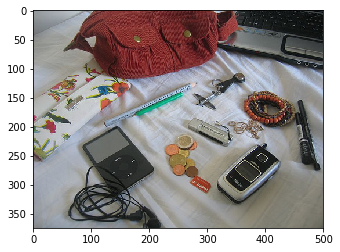

000000370479
Actual:    startseq kitchen with chef pointing at another person near the stove endseq
Predicted:  startseq group of people gathered around kitchen counter endseq


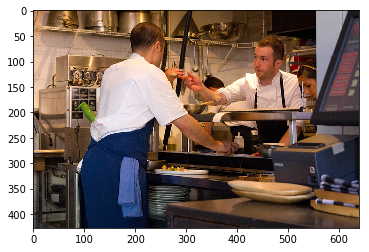

000000186308
Actual:    startseq jumbo jet lifting off the runway at takeoff endseq
Predicted:  startseq british airways plane taking off at the airport endseq


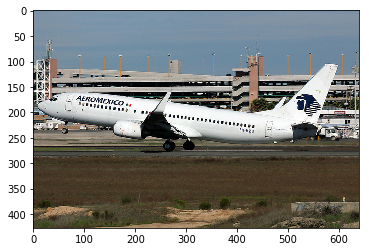

000000269945
Actual:    startseq booth for or by firefighters at fair endseq
Predicted:  startseq group of teddy bears that are sitting next to each other endseq


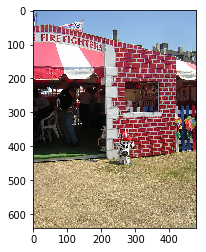

000000569767
Actual:    startseq two people are riding horses down trail endseq
Predicted:  startseq herd of cattle grazing on top of grass covered field endseq


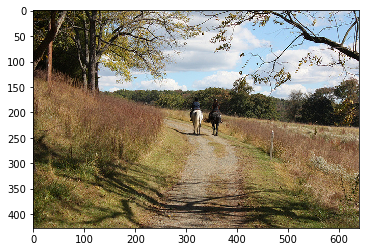

000000458339
Actual:    startseq toilet in bathroom filled with human waste endseq
Predicted:  startseq bath room with tiled floor and toilet endseq


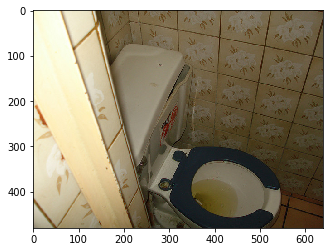

000000136433
Actual:    startseq person who is walking with some luggage behind them endseq
Predicted:  startseq black and white photograph of man playing guitar endseq


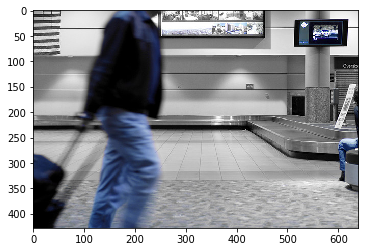

000000283222
Actual:    startseq above view of someone with skis on their feet and snow endseq
Predicted:  startseq skateboarder is in mid air during trick endseq


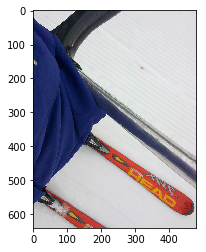

000000302945
Actual:    startseq black and white sign named north arizona near another smaller sign endseq
Predicted:  startseq couple of street signs that read types of information endseq


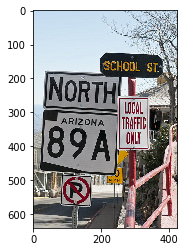

000000492719
Actual:    startseq bathroom with white sink toilet and bathtub and marbled countertop endseq
Predicted:  startseq bath room with white toilet and sink endseq


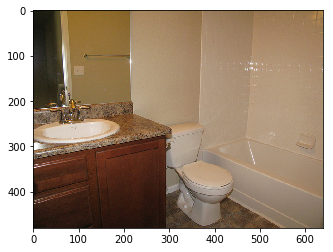

0.13650598977149334

In [91]:
evaluate_model1(model, train_descriptions,"coco/full/features.h5", word_to_index, max_length)

000000529966
Actual:    startseq two bowls of oranges are sitting on metal surface endseq
Predicted:  startseq variety of fruits and vegetables on table endseq


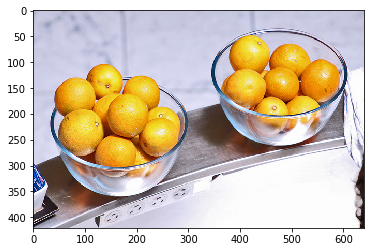

000000125062
Actual:    startseq line of small teddy bears are in front of several dvd cases endseq
Predicted:  startseq group of teddy bears sitting next to each other endseq


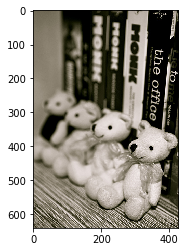

000000559160
Actual:    startseq boy in sports jersey holds skateboard in right hand endseq
Predicted:  startseq there is man riding skate board endseq


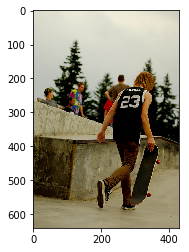

000000266409
Actual:    startseq man that has ski and is standing in the snow endseq
Predicted:  startseq group of cross country paused on cross country path endseq


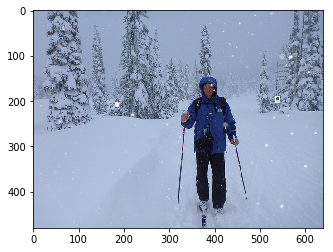

000000154705
Actual:    startseq computer sitting on top of white table with another computer endseq
Predicted:  startseq living room filled with lots of different computer screens endseq


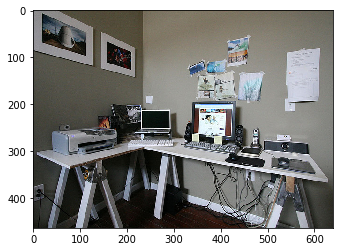

000000031620
Actual:    startseq woman in white dress and man in gray stand near cake on white table under white canopy endseq
Predicted:  startseq group of people who are sitting around table endseq


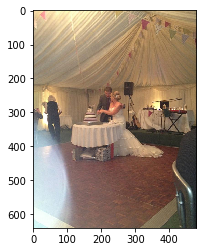

000000250901
Actual:    startseq three people opening wrapped sandwich out on the grass endseq
Predicted:  startseq group of people who are eating some kind of pizza endseq


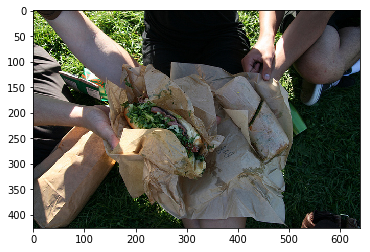

000000528862
Actual:    startseq group of giraffes wonder around in fenced off area with other animals endseq
Predicted:  startseq group of giraffes walking in front of trees endseq


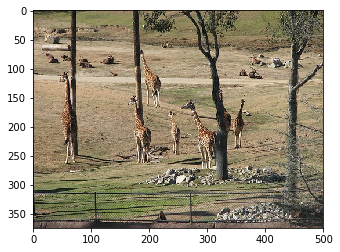

000000526751
Actual:    startseq boat stowed up on the beaches on sand endseq
Predicted:  startseq an image of boat in the water next to waterway endseq


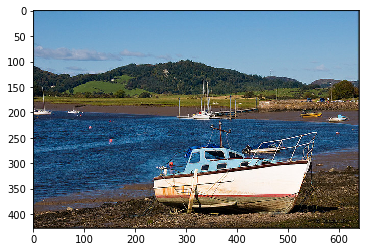

000000109055
Actual:    startseq cat sitting next to bunch of bikes parked next to each other endseq
Predicted:  startseq bunch of orange cones parked next to each other endseq


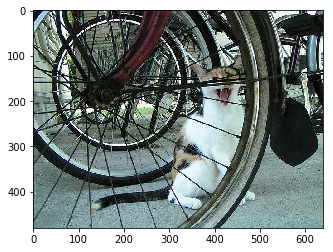

0.09066516969251226

In [93]:
evaluate_model1(model, val_descriptions,"coco/full/val_features.h5", word_to_index, max_length,dataset="val2017")